# Imports

In [344]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import cycle

# Loads

In [345]:
inputh_path='../../data'
df_train = pd.read_csv(f'{inputh_path}/df_train.csv', index_col=0)
df_validation = pd.read_csv(f'{inputh_path}/df_validation.csv', index_col=0)
df_validation_score = pd.read_csv(f'{inputh_path}/df_validation_score.csv', index_col=0)
df_data_type = pd.read_csv(f'{inputh_path}/df_data_type.csv', index_col=0)

# Define features and labels

In [346]:
X_train = df_train.drop(columns=['quality_category'], errors='ignore')  # Training features
y_train = df_train['quality_category']  # Training target labels (encoded)

X_validation = df_validation.drop(columns=['quality_category'], errors='ignore')  # Validation features
y_validation = df_validation['quality_category']

# Train model

##### We are going to compare two GBT models (hypertuning : max_depth which controls the maximum depth of each tree in the ensemble. This parameter plays a critical role in controlling the complexity and performance of the model (eg underfitting vs overfitting))

In [367]:
gbt_model_1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)
gbt_model_3 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [368]:
gbt_model_1.fit(X_train, y_train)
gbt_model_3.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

# Test model

In [369]:
y_pred_1 = gbt_model_1.predict(X_validation)
y_pred_3 = gbt_model_3.predict(X_validation)

In [370]:
print("y_validation type:", y_validation.squeeze().dtype)
print("y_pred type:", y_pred_1.dtype)
print("Unique values in y_validation:", y_validation.squeeze().unique())
print("Unique values in y_pred:", y_pred_1)

y_validation type: int64
y_pred type: int64
Unique values in y_validation: [4 3 2 1]
Unique values in y_pred: [4 3 3 3 3 3 2 2 1 2 2 3 2 2 4 2 2 3 3 2 1 2 2 3 2 3 2 3 2 2 2 1 2 3 3 2 2
 2 2 2 1 2 4 3 2 3 2 4 3 3 2 4 3 3 4 2 3 4 2 3 4 2 2 3 2 2 3 2 3 2 3 2 4 3
 2 3 2 3 3 2 4 3 3 2 2 1 1 3 1 3 2 2 3 2 1 2 2 2 2 3 3 3 3 1 3 2 4 2 4 3 2
 3 2 2 3 2 3 3 2 2 2 2 1 1 2 4 3 2 2 3 2 4 3 2 2 3 2 3 3 2 1 2 3 2 2 3 3 2
 2 2 4 3 3 2 3 3 2 2 4 3 1 2 1 3 2 2 1 3 3 3 3 3 2 3 2 2 3 4 3 3 2 2 2 1 2
 2 2 3 4 3 4 2 1 2 2 3 3 3 3 2 2 2 2 2 3 3 2 2 3 4 4 2 3 2 3 2 2 2 3 3 3 2
 1 2 3 3 2 3 2 2 3 2 1 2 3 3 1 3 4 3]


# Validation metrics

## Accuracy

In [371]:
accuracy_1 = accuracy_score(y_validation, y_pred_1)
print("Accuracy 1:", accuracy_1)

accuracy_3 = accuracy_score(y_validation, y_pred_3)
print("Accuracy 3:", accuracy_3)

Accuracy 1: 0.9125
Accuracy 3: 0.9583333333333334


## Classification report

In [372]:
print("\nClassification 1 Report:\n", 
      classification_report(y_validation, y_pred_1, target_names=['Low', 'Medium', 'High', 'Premium']))


Classification 1 Report:
               precision    recall  f1-score   support

         Low       0.90      0.78      0.84        23
      Medium       0.89      0.94      0.91       102
        High       0.93      0.91      0.92        92
     Premium       0.95      0.91      0.93        23

    accuracy                           0.91       240
   macro avg       0.92      0.89      0.90       240
weighted avg       0.91      0.91      0.91       240



In [374]:
print("\nClassification 3 Report:\n", 
      classification_report(y_validation, y_pred_3, target_names=['Low', 'Medium', 'High', 'Premium']))


Classification 3 Report:
               precision    recall  f1-score   support

         Low       0.95      0.91      0.93        23
      Medium       0.97      0.93      0.95       102
        High       0.94      0.99      0.96        92
     Premium       1.00      1.00      1.00        23

    accuracy                           0.96       240
   macro avg       0.97      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



## ROC-AUC

In [375]:
y_validation_binarized = label_binarize(y_validation, classes=[1, 2, 3, 4])
n_classes = y_validation_binarized.shape[1]

y_validation_proba_1 = gbt_model_1.predict_proba(X_validation)
y_validation_proba_3 = gbt_model_3.predict_proba(X_validation)

In [376]:
fpr = dict()
tpr = dict()
roc_auc = dict() 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_validation_binarized[:, i], y_validation_proba_1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

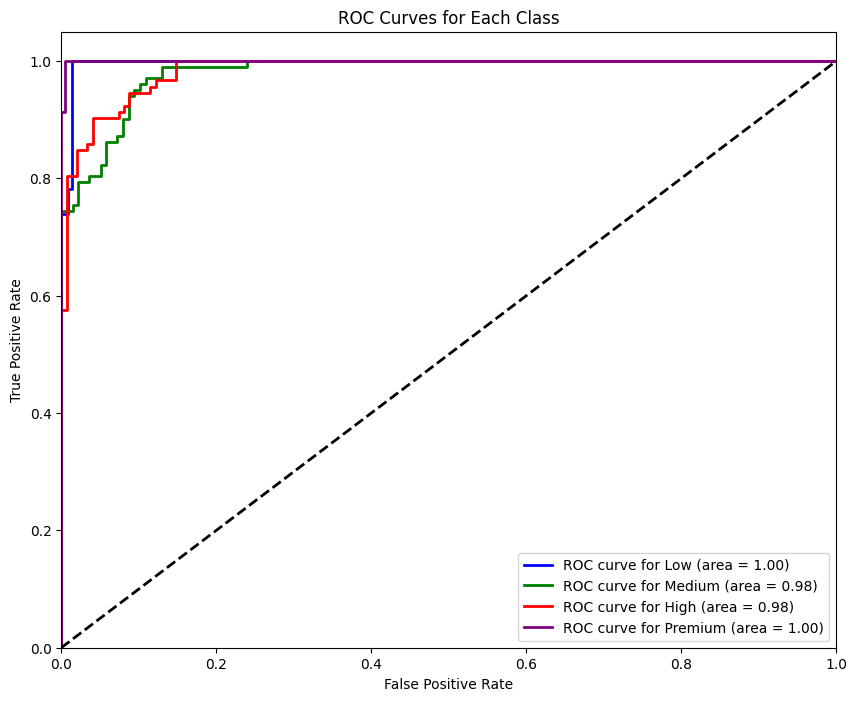

In [377]:
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'green', 'red', 'purple'])
class_names = ['Low', 'Medium', 'High', 'Premium']

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_name} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

In [378]:
fpr = dict()
tpr = dict()
roc_auc = dict() 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_validation_binarized[:, i], y_validation_proba_3[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

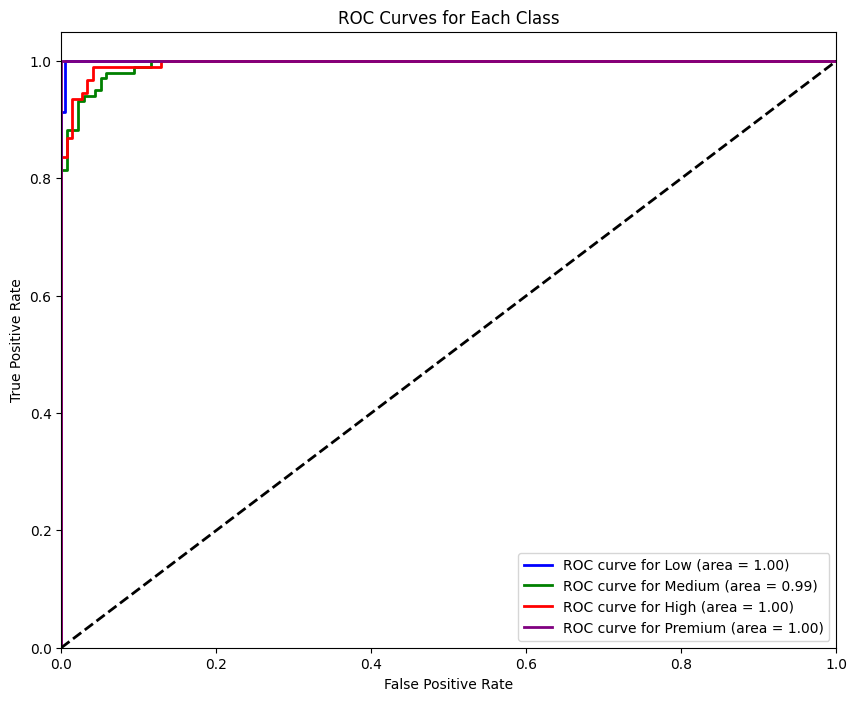

In [379]:
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'green', 'red', 'purple'])
class_names = ['Low', 'Medium', 'High', 'Premium']

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_name} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

# Pseudo quality score

In [380]:
class_scores = {
    1: 1.25,    # Midpoint of Low: 1.0 to 1.50
    2: 2.0,    # Midpoint of Medium: 1.51 to 2.50
    3: 3.0,    # Midpoint of High: 2.51 to 3.48
    4: 3.75    # Midpoint of Premium: 3.51 to 3.97
}

In [381]:
weights = np.array([class_scores[1], class_scores[2], class_scores[3], class_scores[4]])

In [383]:
y_validation_1_proba_df = pd.DataFrame(
    y_validation_proba_1, index=y_validation.index, columns=['Low', 'Medium', 'High', 'Premium'])

y_validation_3_proba_df = pd.DataFrame(
    y_validation_proba_3, index=y_validation.index, columns=['Low', 'Medium', 'High', 'Premium'])

In [384]:
pseudo_quality_scores_1 = y_validation_1_proba_df @ weights
pseudo_quality_scores_3 = y_validation_3_proba_df @ weights 

In [385]:
pseudo_quality_scores_1

1178    3.622725
865     2.965196
101     2.874179
439     2.818173
58      2.722009
          ...   
382     2.774478
867     1.420339
542     2.811893
1193    3.499538
874     2.701077
Length: 240, dtype: float64

In [386]:
df_validation_score

,quality_score
1178,3.530156
865,3.180000
101,3.160000
439,2.780000
58,2.870000
...,...
382,2.860000
867,1.490000
542,2.640000
1193,3.560807


In [387]:
df_pseudo_quality_scores_1 = pd.DataFrame(pseudo_quality_scores_1, columns=['Pseudo Quality Score'])
comparison_df = pd.merge(df_validation_score, df_pseudo_quality_scores_1, left_index=True, right_index=True)
comparison_df.head(10)

,quality_score,Pseudo Quality Score
1178,3.530156,3.622725
865,3.180000,2.965196
101,3.160000,2.874179
439,2.780000,2.818173
58,2.870000,2.722009
1120,3.510000,3.302770
323,2.680000,2.471480
974,1.850000,2.028694
411,1.280000,1.390649
855,2.260000,2.107311


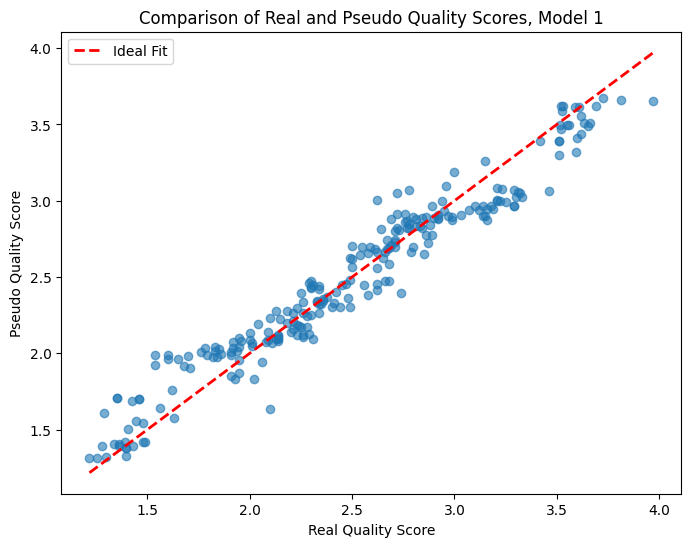

In [392]:
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['quality_score'], comparison_df['Pseudo Quality Score'], alpha=0.6)
plt.plot([comparison_df['quality_score'].min(), comparison_df['quality_score'].max()],
         [comparison_df['quality_score'].min(), comparison_df['quality_score'].max()],
         color='red', linestyle='--', linewidth=2, label="Ideal Fit")

plt.xlabel("Real Quality Score")
plt.ylabel("Pseudo Quality Score")
plt.title("Comparison of Real and Pseudo Quality Scores, Model 1")
plt.legend()
plt.show()

In [389]:
r2 = r2_score(comparison_df['quality_score'], comparison_df['Pseudo Quality Score'])
print("R² (Coefficient of Determination):", r2)

R² (Coefficient of Determination): 0.9404410760602909


In [394]:
df_pseudo_quality_scores_3 = pd.DataFrame(pseudo_quality_scores_3, columns=['Pseudo Quality Score'])
comparison_df = pd.merge(df_validation_score, df_pseudo_quality_scores_3, left_index=True, right_index=True)
comparison_df.head(10)

,quality_score,Pseudo Quality Score
1178,3.530156,3.747447
865,3.180000,2.997180
101,3.160000,2.992262
439,2.780000,2.963835
58,2.870000,2.901465
1120,3.510000,3.743373
323,2.680000,2.915356
974,1.850000,2.001566
411,1.280000,1.261717
855,2.260000,2.042466


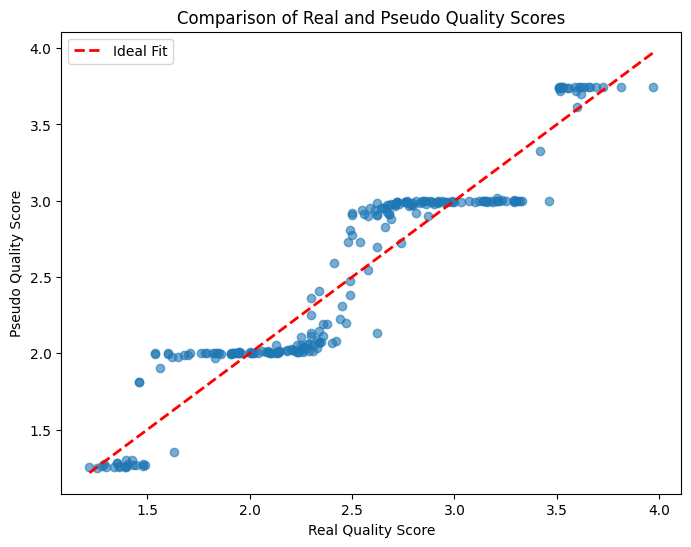

In [395]:
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['quality_score'], comparison_df['Pseudo Quality Score'], alpha=0.6)
plt.plot([comparison_df['quality_score'].min(), comparison_df['quality_score'].max()],
         [comparison_df['quality_score'].min(), comparison_df['quality_score'].max()],
         color='red', linestyle='--', linewidth=2, label="Ideal Fit")

plt.xlabel("Real Quality Score")
plt.ylabel("Pseudo Quality Score")
plt.title("Comparison of Real and Pseudo Quality Scores")
plt.legend()
plt.show()

In [396]:
r2 = r2_score(comparison_df['quality_score'], comparison_df['Pseudo Quality Score'])
print("R² (Coefficient of Determination):", r2)

R² (Coefficient of Determination): 0.8950237334299567


# But what decides the quality of the grape ?

analysis will be made in the feature analysis part

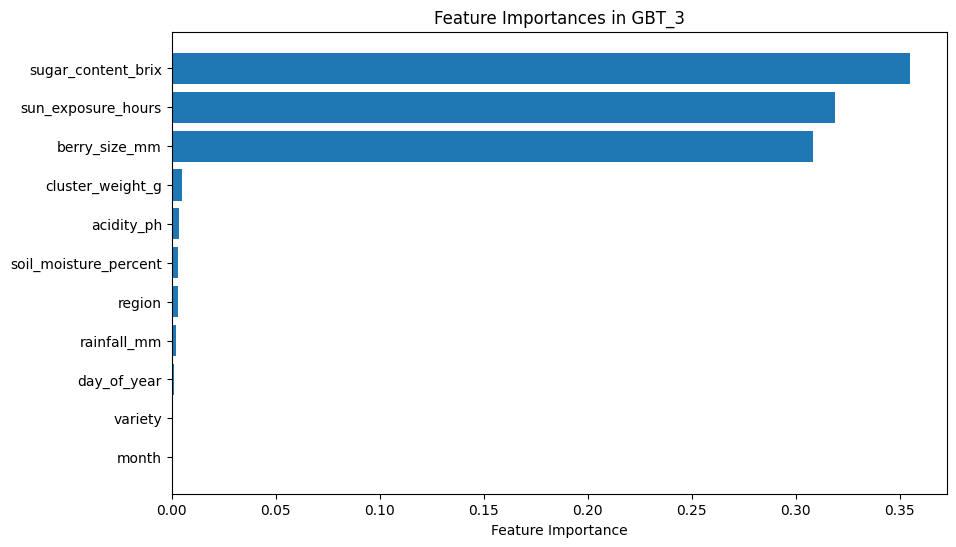

In [398]:
importances = gbt_model_3.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances in GBT_3")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), sorted_feature_names)
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.show()